In [1]:
import math
import random
# import minigrid
import numpy as np
import matplotlib
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
# from array2gif import write_gif
# from minigrid.wrappers import ImgObsWrapper, FullyObsWrapper


import gym_examples
from models import *
from utils import *

pygame 2.1.0 (SDL 2.0.16, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
num_skills = 8
# skill_eps_len = 10  # 90 10
# skill_eps_count = 10
num_episodes = 1000  # 600
# discount = 0.99
# final_step_discount = 0.99
lr_pred = 1e-4
# lr_reg = 1e-4
lr_policy = 1e-4
# lr_extractor = 1e-4
BATCH_SIZE = 32 # 64  # 128
GAMMA = 0.99
EPS_START = 0.9
EPS_MIN = 0.05
EPS_END = 0
# EPS_DECAY = 50000
TAU = 0.005
# features_dim = 32 # 128
hid_dim = 32
q_memory = ReplayMemory(1000)
predictor_memory = MemoryDataset(200) # 300-600
terminate_prob = 0.05

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
env = gym.make('gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.OneHot(env)
# env = gym_examples.AgentLocation(env)
# env = gym_examples.FullFrame(env)

n_actions = env.action_space.n
obs_dim = env.observation_space.shape[-1]
# obs, info = env.reset()
print(obs_dim)

100


/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(


In [4]:
predictor_net = Head(obs_dim * 2, num_skills, hid_dim=hid_dim, if_prob=False).to(device)

policy_net = Head(obs_dim, n_actions*num_skills, hid_dim=hid_dim,).to(device)
target_net = Head(obs_dim, n_actions*num_skills, hid_dim=hid_dim,).to(device)
target_net.load_state_dict(policy_net.state_dict())

pred_optimizer = optim.AdamW(predictor_net.parameters(), lr_pred, amsgrad=True)
policy_optimizer = optim.AdamW(policy_net.parameters(), lr_policy, amsgrad=True)

In [5]:
it = 0
def select_action(state, skill, eps_done):
    global it
    eps_threshold = epsilon(EPS_START, EPS_END, eps_done, EPS_MIN)
    if it > 5 and random.random() < terminate_prob:
        it = 0
        return None
    elif random.random() > eps_threshold:
        it += 1
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            q_values = policy_net(state).reshape((-1, n_actions, num_skills))[:,:, skill]
            return q_values.max(1).indices.view(-1, 1)
    else:
        it += 1
        return torch.tensor([[env.action_space.sample()]], device=device,) # dtype=torch.long

In [6]:
def compute_td_error():
    if len(q_memory) < BATCH_SIZE:
        return
    transitions = q_memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(
        tuple(map(lambda s: s is not None, batch.next_state)),
        device=device,
        dtype=torch.bool,
    )
    non_final_next_states = torch.cat(
        [s for s in batch.next_state if s is not None]
    )
    state_batch =  torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    skill_batch = torch.cat(batch.skill)
    state_action_values = policy_net(state_batch).reshape((-1, n_actions, num_skills))[torch.arange(BATCH_SIZE), action_batch.squeeze().int()] # [B,N_Skills]

    next_state_values = torch.zeros((BATCH_SIZE, num_skills), device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = (
            target_net(non_final_next_states).reshape(-1, n_actions, num_skills)
            .max(1)
            .values
        )
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.unsqueeze(1)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    td_error = criterion(
        state_action_values, expected_state_action_values
    )
    # print(next_state_values * GAMMA, reward_batch.unsqueeze(1))
    # print(td_error)

    # Optimize the model
    policy_optimizer.zero_grad()
    td_error.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    policy_optimizer.step()

    return td_error

In [7]:
def update_pred():
    train_dataset, valid_dataset = torch.utils.data.random_split(predictor_memory, [0.8, 0.2])
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
    stopper = EarlyStopper(patience=5, min_delta=-0.001, if_save=False)

    for epoch in tqdm(range(5000)):
        predictor_net.train()
        for batch, (X, y) in enumerate(train_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = predictor_net(X)
            # print(pred.shape, y.shape)
            loss = torch.nn.functional.cross_entropy(pred, y)

            # Backpropagation
            loss.backward()
            pred_optimizer.step()
            pred_optimizer.zero_grad()
        
        predictor_net.eval()
        valid_losses = 0
        num_batch = 0
        for batch, (X, y) in enumerate(valid_dataloader):
            X, y = X.to(device), y.to(device)

            # Compute prediction error
            pred = predictor_net(X)
            loss = torch.nn.functional.cross_entropy(pred, y)
            num_batch += 1
            valid_losses += loss

        valid_loss = valid_losses/num_batch

        # if stopper.early_stop(valid_loss):
        #     break
        
    predictor_net.train()
    return valid_loss


In [8]:
td_error_list = []
reward_list = []
pred_loss_list = []
# reg_loss_list = []

for i_episode in range(num_episodes):
    # Initialize the environment and get it's state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(
        0
    )
    skill = torch.tensor(
        [random.choice([*range(num_skills)])], device=device
    ).unsqueeze(
        0
    )  # [1, 1]

    secondary_memory = []
    action = None
    while action is None:
        action = select_action(state, skill.item(), i_episode)
    while action is not None:
        observation, _, terminated, truncated, _ = env.step(
            action.item()
        )  # ignore reward
        done = terminated or truncated
        next_state = torch.tensor(
            observation, dtype=torch.float32, device=device
        ).unsqueeze(0)

        if terminated:
            secondary_memory.append((state, action, None))
        else:
            secondary_memory.append((state, action, next_state))

        state = next_state
        action = select_action(state, skill.item(), i_episode)

        if done:
            break

    initial_state = secondary_memory[0][0]
    init_terminal = torch.cat((initial_state, state), dim=1)
    predictor_memory.add((init_terminal.squeeze(0), skill.squeeze()))

    if i_episode % 32 == 31:
        pred_loss = update_pred()
        pred_loss_list.append(pred_loss)
        with torch.no_grad():
            for transition in q_memory.memory:
                # TODO: change this
                transition._replace(
                    reward = - torch.nn.functional.cross_entropy(predictor_net(init_terminal), skill.squeeze(0).to(device)).unsqueeze(0)
                )

    with torch.no_grad():
        reward = - torch.nn.functional.cross_entropy(predictor_net(init_terminal), skill.squeeze(0).to(device)).unsqueeze(0) # - prev_regularizer_net(state_feature)[:, skill.item()]
        # print(reward)

    for s, a, ns in secondary_memory:
        q_memory.push(s, a, ns, skill, reward, init_terminal)

    # train 10 times
    # TODO: prioritized queue
    # td_error = None
    if i_episode % 32 == 31:
        for j in tqdm(range(10)):
            td_error = compute_td_error()
        print(f"Episode {i_episode} done.")

        if td_error:
            target_net.load_state_dict(policy_net.state_dict())
            td_error_list.append(td_error)
    # else:
    #     td_error_list.append(torch.tensor(0))

    if i_episode > 0 and not i_episode % 100:
        torch.save(
            target_net.state_dict(), "target_net_{}.dict".format(i_episode)
        )

print("Complete")

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(
  1%|          | 54/5000 [00:00<00:09, 538.07it/s]

100%|██████████| 10/10 [00:00<00:00, 42.42it/s]


Episode 31 done.


100%|██████████| 10/10 [00:00<00:00, 1220.41it/s]


Episode 63 done.


100%|██████████| 10/10 [00:00<00:00, 1112.19it/s]


Episode 95 done.


100%|██████████| 10/10 [00:00<00:00, 1185.64it/s]


Episode 127 done.


100%|██████████| 10/10 [00:00<00:00, 1114.47it/s]


Episode 159 done.


100%|██████████| 10/10 [00:00<00:00, 1165.89it/s]


Episode 191 done.


100%|██████████| 10/10 [00:00<00:00, 1110.63it/s]


Episode 223 done.


100%|██████████| 10/10 [00:00<00:00, 1137.50it/s]


Episode 255 done.


100%|██████████| 10/10 [00:00<00:00, 1127.74it/s]


Episode 287 done.


100%|██████████| 10/10 [00:00<00:00, 1102.05it/s]


Episode 319 done.


100%|██████████| 10/10 [00:00<00:00, 1087.76it/s]


Episode 351 done.


100%|██████████| 10/10 [00:00<00:00, 1117.80it/s]


Episode 383 done.


100%|██████████| 10/10 [00:00<00:00, 1097.30it/s]


Episode 415 done.


100%|██████████| 10/10 [00:00<00:00, 1240.22it/s]


Episode 447 done.


100%|██████████| 10/10 [00:00<00:00, 1283.37it/s]


Episode 479 done.


100%|██████████| 10/10 [00:00<00:00, 1164.08it/s]


Episode 511 done.


100%|██████████| 10/10 [00:00<00:00, 1121.08it/s]


Episode 543 done.


100%|██████████| 10/10 [00:00<00:00, 1159.80it/s]


Episode 575 done.


100%|██████████| 10/10 [00:00<00:00, 1103.27it/s]


Episode 607 done.


100%|██████████| 10/10 [00:00<00:00, 1291.99it/s]


Episode 639 done.


100%|██████████| 10/10 [00:00<00:00, 1095.55it/s]


Episode 671 done.


100%|██████████| 10/10 [00:00<00:00, 1097.67it/s]


Episode 703 done.


100%|██████████| 10/10 [00:00<00:00, 1112.22it/s]


Episode 735 done.


100%|██████████| 10/10 [00:00<00:00, 1239.05it/s]


Episode 767 done.


100%|██████████| 10/10 [00:00<00:00, 1098.07it/s]


Episode 799 done.


100%|██████████| 10/10 [00:00<00:00, 1125.63it/s]


Episode 831 done.


100%|██████████| 10/10 [00:00<00:00, 1378.07it/s]


Episode 863 done.


100%|██████████| 10/10 [00:00<00:00, 1094.69it/s]


Episode 895 done.


100%|██████████| 10/10 [00:00<00:00, 1151.74it/s]


Episode 927 done.


100%|██████████| 10/10 [00:00<00:00, 1102.11it/s]


Episode 959 done.


100%|██████████| 10/10 [00:00<00:00, 1257.55it/s]

Episode 991 done.
Complete


In [32]:
env = gym.make("gym_examples/GridWorld-v0", size=10, render_mode="rgb_array")
# env = gym.make('gym_examples:gym_examples/GridWorld-v0', size=10, render_mode="rgb_array")
env = gym_examples.OneHot(env)
env = gym.wrappers.RecordVideo(
    env,
    video_folder="eval",
    name_prefix="eval",
    episode_trigger=lambda x: True,
)
num_eval_episodes = 8
map = None

for episode_num in range(num_eval_episodes):
    obs, _ = env.reset()

    for t in range(100):
        obs = torch.tensor(
            obs, dtype=torch.float32, device=device
        ).unsqueeze(0)
        action = (
            target_net(obs).reshape(-1, n_actions, num_skills)[:,:, episode_num]
            .max(1)
            .indices.view(1, 1)
        )
        # action = select_action(obs, 4, 100000)
        
        if action is not None:
            obs, reward, terminated, truncated, _ = env.step(action.item())
            
        done = terminated | truncated

        if done or action is None:
            break
    if map is not None:
        map += (1+episode_num)*obs
    else:
        map = (1+episode_num)*obs
print(map.reshape((10, 10)))

env.close()

# [0. 0. 0. 0. 7. 4. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [5. 0. 0. 0. 0. 0. 3. 0. 0. 8.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
# [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(
/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/wrappers/record_video.py:94: UserWarning: WARN: Overwriting existing videos at /home/zhaoyutian/Documents/rl_experiments/eval folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


0
1
2
3
Moviepy - Building video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4.
Moviepy - Writing video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4



t:   0%|          | 0/6 [00:00<?, ?it/s, now=None]

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(


Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-0.mp4
4
5
6
7
[[0. 0. 0. 0. 7. 4. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [5. 0. 0. 0. 0. 0. 3. 0. 0. 8.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [6. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 2. 0. 0. 0. 0. 0.]]
Moviepy - Building video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-1.mp4.
Moviepy - Writing video /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-1.mp4



Moviepy - Done !
Moviepy - video ready /home/zhaoyutian/Documents/rl_experiments/eval/eval-episode-1.mp4


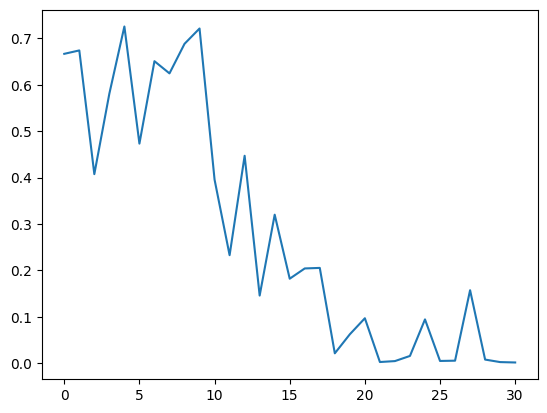

In [30]:
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in pred_loss_list])

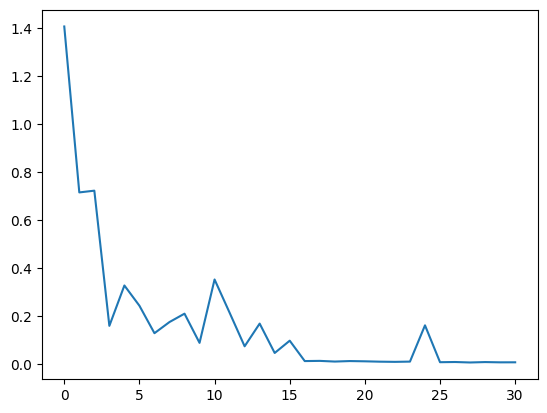

In [31]:
plt.plot([i.item() if type(i) == torch.Tensor else 0 for i in td_error_list])

In [49]:
obs, _ = env.reset()

input = torch.cat((torch.tensor(obs, dtype=torch.float, device=device).unsqueeze(0).repeat(100, 1), torch.eye(100).to(device)),dim=1)
state_skills = predictor_net(input)
state_skill_map = torch.argmax(state_skills, 1).reshape((10, 10)) # untouched?
state_skill_value = torch.max(state_skills, 1).values.reshape((10, 10))
skill_state = torch.argmax(state_skills, 0)
skill_state_value = torch.max(state_skills, 0).values

/home/zhaoyutian/Documents/nlp/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.size to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.size` for environment variables or `env.get_wrapper_attr('size')` that will search the reminding wrappers.
  logger.warn(


In [42]:
state_skill_map

tensor([[0, 0, 0, 0, 6, 3, 0, 0, 0, 0],
        [0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 6, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [4, 4, 4, 4, 5, 7, 2, 2, 7, 7],
        [0, 0, 0, 5, 0, 0, 0, 0, 0, 0],
        [5, 0, 5, 5, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]], device='cuda:0')

In [47]:
skill_state_map = torch.zeros((10, 10))
for idx, i in enumerate(skill_state):
    r = int(i/10)
    c = i%10
    skill_state_map[r][c] = 1+idx
skill_state_map

tensor([[0., 0., 0., 0., 7., 4., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [5., 0., 0., 0., 0., 0., 0., 3., 0., 8.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [6., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 2., 0., 0., 0., 0., 0.]])